<a href="https://colab.research.google.com/github/arahrooh31/UCLA_BE223C/blob/Keane_temp/VGG_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VGG_CLASSIFY


*   This function will take in an input file and ROI and process a 3 class classification 
*   The final output will be a Cancer, No Cancer decision for the ROI given

USAGE:




In [1]:
import os
import sys  #to set local import folder
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc  #debug memory leaks in matplotlib
import csv #read in description files

from google.colab.patches import cv2_imshow


import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
#show model design parameters with torchsummary
import torchsummary
from torchsummary import summary
from torch import FloatTensor
from torch import tensor
from torch.utils.data import DataLoader
from torch import nn


from torchvision import transforms  #get normalization functions

#
# Read Data from google drive
#
from google.colab import drive #for loading gdrive data
from google.colab import files
################################################################################
#
# Load data from google drive
#

drive.mount('/content/gdrive')

#
# SET LOCAL IMPORT DIRECTORY FOR .PY FILES
#
sys.path.append('/content/gdrive/My Drive/DBT_WORKSPACE/DBT_PY_FILES')
!ls '/content/gdrive/My Drive/DBT_WORKSPACE/DBT_PY_FILES'
#from CustomImageDataset import CustomImageDataset
from VGG16 import VGG16

# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug
!pip3 install -q pickle5

import pydicom #to read dicom files
from pydicom import dcmread
import pickle5 as pickle; #generic storage of image array




### Enable GPU, if present
train_on_gpu = torch.cuda.is_available()
if (train_on_gpu):
    !nvidia-smi -L
    !nvidia-smi 
    dev=torch.device("cuda")
else:
    print('GPU NOT FOUND!!! USING CPU INSTEAD!!!!!')




data_dir = '/content/gdrive/My Drive/DBT_DATA/IMG_ARRAYS'
patch_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES' 
model_dir = '/content/gdrive/My Drive/BE223C_SPRING_2021/MODEL_SAVE'
tensorboard_dir = '/content/gdrive/My Drive/BE223C_SPRING_2021/TENSORBOARD_SUMMARIES'






#from get_dirs import get_dirs



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
CustomImageDataset.py  __pycache__  VGG16.py
VGG16(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (vgg16_stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), 

In [26]:
def create_augmented_data(image_data,flip = 1,rot90=1,rot180=1,rot270=1,patchx =244,patchy=244):
    #flip and rotate the data to make new data files

    output90 = np.zeros([3,patchx,patchy])
    output180 = np.zeros([3,patchx,patchy])
    output270 = np.zeros([3,patchx,patchy])
    outputflip = np.zeros([3,patchx,patchy])

    print(np.shape(output90))

    for ii in range(0,np.shape(image_data)[0]):
        image90 = np.rot90(image_data[ii,:,:])
        image180 = np.rot90(image_data[ii,:,:],k=2)
        image270 = np.rot90(image_data[ii,:,:],k=3)
        imageflip = np.fliplr(image_data[ii,:,:])
        output90[ii,:,:] = image90
        output180[ii,:,:] = image180
        output270[ii,:,:] = image270
        outputflip[ii,:,:] = imageflip
    plt.imshow(output90[1,:,:])


    return output90, output180, output270, outputflip


In [41]:


class TestImageDataset(): #Dataset):
    def __init__(self, patch_data,file_count=1,transform=None, target_transform=None):
        #self.img_labels = pd.read_csv(annotations_file)
        self.patch_data = patch_data

        self.file_count = file_count

        self.transform = transform
        self.target_transform = target_transform

        



    def image_normalize(self,image):
        #replace with the more tensor friendly normalize once tensor shapes confirmed
        image = image/65535.0
        return image


    def __len__(self):
        return self.file_count #len(self.file_list) #99 #len(self.img_labels)

    def __getitem__(self, index):

        image = self.patch_data
        image.astype(float)

        #fname = self.file_list[index]

        #VERIFY THE IMAGES ARE ALL THE SAME 3x244x244
        shapes = image.shape
        assert (shapes[0] == 3),"Image slice error: {0}".format(fname)
        assert (shapes[1] == 244), print('Image row error: ',fname)
        assert (shapes[2] == 244), print('Image column error: ',fname)
        #if (shapes[0] != 3 and shapes[1] != 244 and shapes[2]!= 244):


        #Normalize the data to 0,1 from 2^16
        image = self.image_normalize(image) #image/65535.0 #image_normalize(image)


        output90, output180, output270, outputflip = create_augmented_data(image,flip = 1,rot90=1,rot180=1,rot270=1)


        out_data = [output90,output180, output270, outputflip]


        sample = {"image": out_data} #, "label": label}
            #sample = file_name
        return sample

In [2]:
def choose_tissue_area(img_data, patch_x,patch_y,slice_selection = 2,debug=0):


    if (debug == 1):  print('slice chosen is ',slice_selection)
    slice_data = img_data[slice_selection,:,:]

    # convert the grayscale image to binary image
    #look for anything >1 and assign that a 1 value. Expectation is that 
    #any area without attenuation will have 0 value -- adjust the lower val
    #if blurred areas need to be brought in. Last 0 is just the default
    #threshold type
    ret,thresh = cv2.threshold(slice_data,1,1,0)


    # calculate moments of binary image
    M = cv2.moments(thresh)
    # calculate x,y coordinate of center
    center_x = int(M["m10"] / M["m00"])
    center_y = int(M["m01"] / M["m00"])
    if (debug == 1):  print('center is ', center_x,center_y)


    # create a patch centered at the centroid location
    patch_lr = center_x-int(patch_x/2),center_x+int(patch_x/2)
    patch_tb = center_y-int(patch_y/2),center_y+int(patch_y/2)
    #        indices = np.where(slice_data!= [0])
    #        coordinates = zip(indices[0], indices[1])

    slice_lower = slice_selection -1
    slice_upper = slice_selection +2
    patch_img = img_data[slice_lower:slice_upper,patch_tb[0]:patch_tb[1],
                         patch_lr[0]:patch_lr[1]]

    total_slices = np.shape(patch_img)
    original_shape = np.shape(img_data)
    assert (total_slices[0] == 3), \
        "Slice was not 3 in Normal create{},{},{}--{}".format(total_slices, \
                                                          slice_lower, slice_upper, original_shape)

    if debug == 1:
        plt.figure()
        plt.imshow(thresh,cmap='bone') #img_data[slice_selection,:,:],cmap='bone')
        plt.text(center_x,center_y,'.')
        plt.text(patch_lr[0],patch_tb[0],'O')
        plt.colorbar()


        #### Draw annotation box
        xcorner = int(patch_lr[0])
        ycorner = int(patch_tb[0])
        xwidth = int(244)
        yheight = int(244)

        rect = patches.Rectangle((xcorner,ycorner),xwidth,yheight,linewidth=2,edgecolor='r',facecolor='none')
        # Get the current reference
        ax = plt.gca()
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.show()


    return patch_img,center_x,center_y


shape of raw input image is  110 1900 2500
1656 2135 10
1543 2068 11
1410 2048 12
1399 2170 13
1321 2074 14
(3, 244, 244)
(3, 244, 244)
(3, 244, 244)
(3, 244, 244)
<class 'dict'>
dict_keys(['image'])
len of temp is  1
<class 'dict'>
dict_keys(['image'])
len of temp is  1
<class 'dict'>
dict_keys(['image'])
len of temp is  1
<class 'dict'>
dict_keys(['image'])
len of temp is  1
counter is at  4


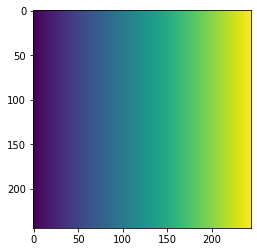

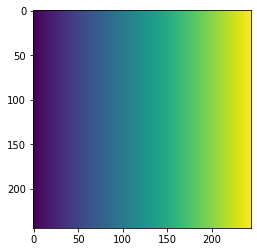

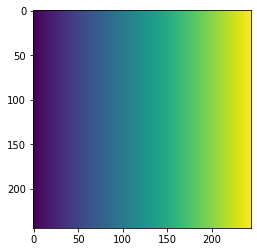

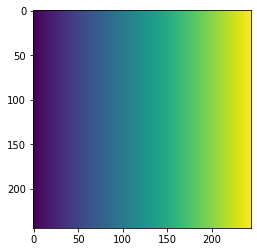

In [65]:
####################################################
# GENERATE RANDOM PATCHES FROM ARGUMENT BOX DATA
####################################################
raw_image = np.uint16(np.random.rand(110,1900,2500))

# Get original image size
islices,irows, icols= np.shape(raw_image)
print('shape of raw input image is ', islices, irows, icols)
for ii in range(0,islices):
    for counter,jj in enumerate(range(0,irows)):
        if (counter %2 == 0):
            raw_image[ii,jj,:] = counter
        else:
            raw_image[ii,jj,:] = counter



start_point  = -1
patch_x = 244
patch_y = 244

#StudyUID,View,Slice,GTClass,pred_X,pred_Y,pred_width,pred_height,confidence
#DBT-S01541,lmlo,15,Normal,,,,,0.22699964046478271
#DBT-S01541,lmlo,16,Normal,17.633377075195312,1543.7889404296875,196.87840270996094,181.398681640625,0.320894330739975
#DBT-S01541,lmlo,16,Normal,17.633377075195312,1543.7889404296875,196.87840270996094,181.398681640625,0.320894330739975
#DBT-S01541,lmlo,17,Normal,24.001001358032227,1543.2220458984375,191.9607696533203,176.679931640625,0.35758641362190247
#DBT-S01541,lmlo,17,Normal,24.001001358032227,1543.2220458984375,191.9607696533203,176.679931640625,0.35758641362190247
#DBT-S01541,lmlo,18,Normal,,,,,0.25522008538246155
#DBT-S01541,lmlo,19,Normal,,,,,0.21641097962856293

box_info = ['testfile',7,1800,125,2200,80]
row_corner = box_info[2]
col_corner = box_info[4]
box_slice = box_info[1]

roi_delta = 0.1


#This is the allowed range of box centers, all within the given ROI
selectable_col = range(box_info[4],box_info[4]+box_info[5])
selectable_row = range(box_info[2],box_info[2]+box_info[3])

desired_boxes = 50
box_safe =0
box_corners = []
counter = 0
while ((box_safe < 5) and (counter < 1e3)):
    counter +=1 #safeguard for while

    #generate a random point within or some % outside of the box limits
    row_corner=np.random.randint(row_corner-row_corner*roi_delta, row_corner+ row_corner*roi_delta)
    col_corner=np.random.randint(col_corner-col_corner*roi_delta, col_corner+ col_corner*roi_delta)
    #check to see if this new corner extends beyond any image end
    if ((row_corner < 0) or (col_corner <0) or 
        (((row_corner + patch_y) > irows) or ((col_corner + patch_x) > icols))):
        #box will extend off image boundary
        #don't let this new bounding box through, redo it
        #print('UNSAFE BOX--REDO ',row_corner,col_corner)
        pass
    else: #This box is safe, use it for calculations
        print(row_corner,col_corner, counter)
        box_safe += 1
        box_corners.append([row_corner, col_corner])

if (len(box_corners) != 5):
    print('Failed to find enough sample boxes')

slice_lower = box_slice - 1
slice_upper = box_slice + 1


#build patches from random boxes
data = {}
for ii in range(0,1): #len(box_corners)):
    row_lims_low, row_lims_high = box_corners[ii][0],box_corners[ii][0]+patch_y
    col_lims_low, col_lims_high = box_corners[ii][1],box_corners[ii][1]+patch_x
    patch_img = raw_image[slice_lower:slice_upper+1,row_lims_low:row_lims_high,col_lims_low:col_lims_high]

    #Do Test Portion here
    #1. Take in random patch, use transforms to make rotations and a flip
    #2. Return those as the batch images
    #3. Run Model over that set
    #4. Take any that match cancer as the label

    #load up with the pre-sized patch images
    all_data = TestImageDataset(patch_data = patch_img,
                                file_count=4, #full_file_count,
                                transform=None, 
                                target_transform=None)

    #del patch_img
    
    dataloader_all = DataLoader(all_data, batch_size=1,shuffle=True, num_workers=2)#, 
    
    count = 0
    for ii in dataloader_all:
        print(type(ii))
        print(ii.keys())
        key = list(ii.keys())
        
        plt.figure()
        temp = ii[key[0]][count]
        print('len of temp is ', len(temp))
        plt.imshow(temp[0,:,:])

        count +=1
    print('counter is at ', count)

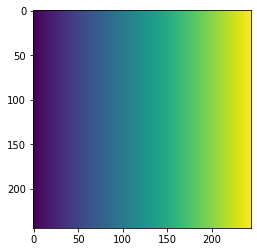

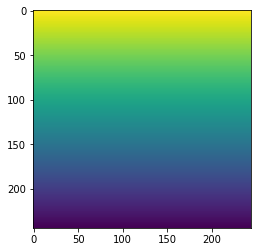

In [75]:
ii['image'][0]
plt.figure()
aa = ii['image'][0]
bb = ii['image'][1]
plt.imshow(aa[0,0,:,:])

plt.figure()
plt.imshow(bb[0,0,:,:])


In [4]:
#
# Read inputs
#

In [5]:
################################################################################
# GET FULL LIST OF FILES IN IMAGE ARRAY DIRECTORY
################################################################################
use_patch_files = 1
if (use_patch_files == 0):
    raw_files = os.listdir(data_dir)
    print('found #files: ',len(raw_files))
else: #patches broken up into directories
    category_folders = os.listdir(patch_dir)
    #raw_files = os.listdir(data_dir)
    #print('found #files: ',len(raw_files))    

if (0):
    #create fake patches for now
    patch_dict = {}
    for counter,filename in enumerate(raw_files):
        #load full array
        full_filename = os.path.join(data_dir,filename)
        img_data = pickle.load( open( full_filename, "rb" ) )
        patch_data = img_data[0:3,:,:]
        patch_dict[counter]= patch_data
        print(full_filename,np.shape(patch_data))

        if (counter > 0):
            break
        
### SKIP ACTIONABLE FOLDER
### Remove actionable folder item from list, since we're no longer using that data
category_folders.remove('ACTIONABLE')

In [6]:
for ii in category_folders:
    print(ii)
    flist = os.listdir(os.path.join(patch_dir,ii))

temp = flist[0].split(sep='_')
print(temp[3])

CANCER
BENIGN
NORMAL
Normal


In [7]:
#generate full file list for use in indexing the dataloader
#this replaces the older loader, which was only inputting Normal
full_file_list = [] #store the full filename of every file
full_category_name = []
for category_folder in category_folders:
            print('------------- ',category_folder)
            file_list = os.listdir(os.path.join(patch_dir,category_folder))
            cat_count = 0
            for file_name in file_list:
                cat_count = cat_count + 1
                full_category_name.append(category_folder)
                full_file_list.append(file_name)
                print(os.path.join(category_folder,file_name))
full_file_count = len(full_file_list)
print(len(full_file_list))
full_file_list[0]

-------------  CANCER
CANCER/DBT-P03915_DBT-S05004_lcc_Cancer_s25_cx417_cy1039_244_244_ROT90.pickle
CANCER/DBT-P03915_DBT-S05004_lcc_Cancer_s25_cx417_cy1039_244_244_ROT180.pickle
CANCER/DBT-P03915_DBT-S05004_lcc_Cancer_s25_cx417_cy1039_244_244_ROT270.pickle
CANCER/DBT-P03915_DBT-S05004_lcc_Cancer_s25_cx417_cy1039_244_244_FLIPH.pickle
CANCER/DBT-P04026_DBT-S01650_rcc1_Cancer_s20_cx1640_cy1074_244_244_ROT90.pickle
CANCER/DBT-P04026_DBT-S01650_rcc1_Cancer_s20_cx1640_cy1074_244_244_ROT180.pickle
CANCER/DBT-P04026_DBT-S01650_rcc1_Cancer_s20_cx1640_cy1074_244_244_ROT270.pickle
CANCER/DBT-P04026_DBT-S01650_rcc1_Cancer_s20_cx1640_cy1074_244_244_FLIPH.pickle
CANCER/DBT-P03915_DBT-S05004_lcc_Cancer_s25_cx417_cy1039_244_244.pickle
CANCER/DBT-P04026_DBT-S01650_rmlo_Cancer_s18_cx1532_cy1382_244_244_ROT90.pickle
CANCER/DBT-P04026_DBT-S01650_rmlo_Cancer_s18_cx1532_cy1382_244_244_ROT180.pickle
CANCER/DBT-P04026_DBT-S01650_rmlo_Cancer_s18_cx1532_cy1382_244_244_ROT270.pickle
CANCER/DBT-P04026_DBT-S01650

'DBT-P03915_DBT-S05004_lcc_Cancer_s25_cx417_cy1039_244_244_ROT90.pickle'

#REPLACE CUSTOMIMAGEDATASET WITH .PY ONCE COMPLETE!!!!

In [8]:
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms  #get normalization functions

class TestImageDataset(): #Dataset):
    def __init__(self, img_dir,category=[],file_count=1,file_list =[],transform=None, target_transform=None):
        #self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.category = category
        self.file_count = file_count
        self.file_list = file_list
        self.transform = transform
        self.target_transform = target_transform
        self.category_name =''
        



    def image_normalize(image):
        #replace with the more tensor friendly normalize once tensor shapes confirmed
        image = image/65535.0
        return image


    def __len__(self):
        return self.file_count #len(self.file_list) #99 #len(self.img_labels)

    def __getitem__(self, index):
        
        fname = self.file_list[index]

        #get label and pull category 
        text_tokens = fname.split(sep='_')
        print('text tokens ',text_tokens)
        label_class = text_tokens[3] #get the label token in 4th position
        self.category_name =  label_class.upper() 


        full_file_name = os.path.join(self.img_dir,self.category_name,fname)
        image = pickle.load( open( full_file_name, "rb" ) )
        image = image.astype(float) #using patch images
        

        #VERIFY THE IMAGES ARE ALL THE SAME 3x244x244
        shapes = image.shape
        assert (shapes[0] == 3),"Image slice error: {0}".format(fname)
        assert (shapes[1] == 244), print('Image row error: ',fname)
        assert (shapes[2] == 244), print('Image column error: ',fname)
        #if (shapes[0] != 3 and shapes[1] != 244 and shapes[2]!= 244):


        #Normalize the data to 0,1 from 2^16
        image = image/65535.0 #image_normalize(image)



        #test out numeric label
        if (label_class in 'Normal'):
            label = 0
        elif (label_class in 'Actionable'):
            print('!!!!! ACTIONABLE PASSED THROUGH')
            stop()
            label = 1
        elif (label_class in 'Benign'):
            label = 1
        else: # (label_class in 'Cancer'):
            label = 2


        #print(full_file_name)


        #read_image(img_path)
        #label = self.img_labels.iloc[idx, 1]
        #if self.transform:
        #    image = self.transform(image)
        #if self.target_transform:
        #    label = self.target_transform(label)
        sample = {"image": image} #, "label": label}
            #sample = file_name
        return sample

In [9]:
def calculate_metrics(labels, y_pred_tags):
    #calculate PRECISION and other metrics to guage the model results
    #get # of true cancer cases, find # of cancer cases falsely predicted
    from sklearn.metrics import average_precision_score

    temp_labels = []
    temp_prediction = []
    true_pos =[]


    #initialize variables for manual calculations
    TP = 0 #true positive
    FP = 0 #false positive
    TN = 0 #true negative
    FN = 0 #false negative
    BP = 0 #benign positive match
    BN = 0 #benign negative match
    num0=0
    num1=0
    num2=0
    for i in range(len(labels)): 
        if y_pred_tags[i]==labels[i]==2:
            TP += 1

        #FP
        if y_pred_tags[i]==2 and labels[i]!=y_pred_tags[i]:
            FP += 1
        #if y_pred_tags[i]==1 and labels[i]!=y_pred_tags[i]:
        #    FP += 1

        #TN
        if labels[i]==y_pred_tags[i]==0:
            TN += 1
        if labels[i]==y_pred_tags[i]==1:
            TN += 1

        #FN
        if y_pred_tags[i]==0 and labels[i]==2: #!=y_pred_tags[i]:
            FN += 1
        if y_pred_tags[i]==1 and labels[i]==2: #!=y_pred_tags[i]:
            FN += 1

        #check to see how benign does
        if (y_pred_tags[i] ==1 and labels[i] != 1):
            BN +=1
        if (y_pred_tags[i] ==1 and labels[i] == 1):
            BP +=1

        if (y_pred_tags[i]==0):
            num0+=1
        elif (y_pred_tags[i] == 1):
            num1+=1
        else:
            num2 +=1

    #F1 Score = 2*(Recall * Precision) / (Recall + Precision)
    print('Predicted Matches #0,#1,#2 = ',num0,num1,num2)
    print('BN Match = ',BN,BP)
    final_accuracy = (TP+TN)/(TP+FP+FN+TN +1e-12)
    print('Accuracy is ',final_accuracy)
    final_precision = TP/(TP+FP + 1e-12)
    print('Precision is ',final_precision)
    final_recall_sens = TP/(TP + FN + 1e-12)
    print('Recall/Sens = ',final_recall_sens)
    f1_score = 2 *(final_recall_sens * final_precision)/(final_recall_sens + final_precision +1e-12)
    print('F1 score = ',f1_score)


    #########################################################################
    # Consolidate the 3 classes into a binary setup. Cancer label is 1, 
    #benign and no cancer are lumped into class 0
    #########################################################################
    for ii in labels:
        if (ii == 2):
            temp_labels.append(1)
        else:
            temp_labels.append(0)

    for ii in y_pred_tags:
        if (ii == 2):
            temp_prediction.append(1)
        else:
            temp_prediction.append(0)
    print(temp_labels)
    print(temp_prediction) 
    print(labels)
    print(y_pred_tags)                  
    average_precision = average_precision_score(temp_labels, temp_prediction)

    print('Average precision-recall score: {0:0.2f}'.format(
        average_precision))
    
    scores = [TP, FP,TN,FN]
    return average_precision, final_accuracy, final_precision, final_recall_sens, f1_score, scores

In [10]:
#Show summary of model setup and move model to the GPU
 #train_on_gpu = torch.cuda.is_available()

bsize = 50

model_vgg16 = VGG16() #.to(device)
model_vgg16 = model_vgg16.float()
print(model_vgg16)


if (train_on_gpu == 1):
    #dev=torch.device("cuda") 
    model_vgg16.to(dev)
    summary(model_vgg16,(3,244,244), batch_size = bsize, device='cuda')
else:
    summary(model_vgg16,(3,244,244), batch_size = bsize)

VGG16(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (vgg16_stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(256, 512, kernel_size=(3, 3),

In [11]:
#
# LOSS FUNCTION SETUP
#
import torch.optim as optim
from torchsummary import summary

import torch
torch.autograd.set_detect_anomaly(True)

#criterion = nn.CrossEntropyLoss()

criterion = nn.CrossEntropyLoss() #weight = weight_numbers)
if (train_on_gpu ==1):
    criterion.cuda(dev)

#OPTIMIZERS
#optimizer = optim.SGD(model_vgg16.parameters(), lr=0.1, momentum = 0.99) #lr=0.001, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

optimizer = torch.optim.Adam(model_vgg16.parameters(), lr=0.000007, weight_decay=0.00000)#lr=0.00005, weight_decay=0.0000)

#add scheduler to adjust learning rates when val gets stuck
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.1)

if (train_on_gpu == 1):
    m = nn.LogSoftmax(dim=1).cuda(dev)
    nll_loss = nn.NLLLoss().cuda(dev)
else:
    m = nn.LogSoftmax(dim=1)
    nll_loss = nn.NLLLoss()

L1loss = nn.L1Loss()

model_vgg16.parameters
#summary(model_vgg16, (3, 224, 224))

<bound method Module.parameters of VGG16(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (vgg16_stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): C

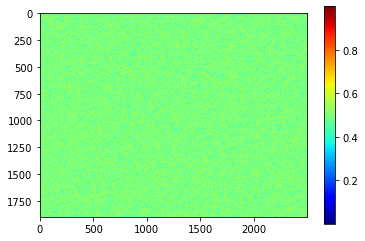

In [12]:
#
# Generate Random image for loading
#
raw_image = np.random.rand(110,1900,2500)

plt.figure()
plt.imshow(raw_image[50,:,:],cmap='jet')
plt.colorbar()

#
# PARSE BOX LOCATIONS
#
box = [13,250,159,2100,180]

In [13]:
model_name = 'vgg16_best_accuracy_93_EPOCH_96_0.04582521319389343'
index_storage_file = os.path.join(tensorboard_dir,'data_index_052521_gpu.pickle')
index_file = os.path.join(tensorboard_dir,'data_index_052521_gpu.pickle') #052021_gpu.pickle') #data_index_last.pickle')

In [14]:
### BYPASS DATALOADER TO MODEL AND TRY A SINGLE FILE

final_file = os.path.join(model_dir,model_name) #'vgg16_best_accuracy_81_EPOCH_79') #95_gpu_051821')#'vgg16_best_accuracy_97_gpu_final')
checkpoint = torch.load(final_file, map_location=torch.device('cpu'))


use_index = 1
if (use_index == 1):
    #[val_index, test_index, file_list]
    validation_saved_index,test_saved_index,saved_flist=pickle.load( open( index_file, "rb" )) 
    test_files=[]
    for ii in test_saved_index:
        test_files.append(full_file_list[ii])
    print('!!!! Using Test Indexed Files ONLY !!!!')
fname = test_files[0]




test_name = os.path.join(patch_dir,category_name,fname)

print('testing file is ', test_name)
print('test file is ',test_files[0])
tfile = [test_files[0]]

model_vgg16.load_state_dict(checkpoint)
model_vgg16.eval()



all_data = TestImageDataset(img_dir=patch_dir,
                                category = full_category_name, 
                                file_count=len(tfile), #full_file_count,
                                file_list = tfile, #flist, #new_file_list, #full_file_list, 
                                transform=None, 
                                target_transform=None)

dataloader_all = DataLoader(all_data, batch_size=bsize,shuffle=True, num_workers=2)

with torch.no_grad():
    for i, data in enumerate(dataloader_all, 0):

        inputs = data['image'].type(FloatTensor)

        if (train_on_gpu):
            inputs = inputs.to(dev) #, labels = inputs.to(dev), labels.to(dev)
        # forward + backward + optimize
        outputs = model_vgg16(inputs) #.permute(0, 1, 2, 3))
        outputs=torch.flatten(outputs, start_dim=1)
        #loss = criterion(outputs, labels)
        y_pred_softmax = torch.log_softmax(outputs, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)

        print('Predicted Label is ', y_pred_tags)


!!!! Using Test Indexed Files ONLY !!!!


NameError: ignored

In [ ]:
##########################################################
# Test against the test dataset to get accuracy results
##########################################################
run_test= 1
if (run_test == 1):
    #Mixing GPU and CPU model saves doesn't seem to map well yet
    final_file = os.path.join(model_dir,model_name) #'vgg16_best_accuracy_81_EPOCH_79') #95_gpu_051821')#'vgg16_best_accuracy_97_gpu_final')
    checkpoint = torch.load(final_file, map_location=torch.device('cpu'))



    
    use_index = 1
    if (use_index == 1):
        #[val_index, test_index, file_list]
        validation_saved_index,test_saved_index,saved_flist=pickle.load( open( index_file, "rb" )) 
        test_files=[]
        for ii in test_saved_index:
            test_files.append(full_file_list[ii])
        print('!!!! Using Test Indexed Files ONLY !!!!')
    else: #use full files      
        bc_files=[]
        for ii in full_file_list:
            if (('Benign' in ii) or ('Cancer' in ii)):
                bc_files.append(ii)
                #print(ii)
    
    #new_file_list=[]
    #for ii in b:
    #    new_file_list.append(full_file_list[ii])


    model_vgg16.load_state_dict(checkpoint)
    model_vgg16.eval()


    #load up with the pre-sized patch images
    all_data = CustomImageDataset(img_dir=patch_dir,
                                    category = full_category_name, 
                                    file_count=len(test_files), #full_file_count,
                                    file_list = test_files, #flist, #new_file_list, #full_file_list, 
                                    transform=None, 
                                    target_transform=None)

    dataloader_all = DataLoader(all_data, batch_size=bsize,shuffle=True, num_workers=2)#, 

    total_accuracy = []
    total_precision = []
    total_average_precision=[] 
    total_final_accuracy = []
    total_final_precision = []
    total_final_recall_sens = []
    total_f1_score =[]
    for epoch in range(0,1):
        with torch.no_grad():
            for i, data in enumerate(dataloader_all, 0):
                print(i)
                # get the inputs; data is a list of [inputs, labels]
                #inputs, labels = data
                inputs = data['image'].type(FloatTensor)
                labels = data['label'] #.type(FloatTensor)

                if (train_on_gpu):
                    inputs, labels = inputs.to(dev), labels.to(dev)

                # forward + backward + optimize
                outputs = model_vgg16(inputs) #.permute(0, 1, 2, 3))

                outputs=torch.flatten(outputs, start_dim=1)
                loss = criterion(outputs, labels.long())


                #print(outputs)
                y_pred_softmax = torch.log_softmax(outputs, dim = 1)
                _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
                #print(y_pred_tags)
                #print(labels)
                correct_pred = (y_pred_tags == labels).float()
                accuracy = correct_pred.sum() / len(correct_pred)
                #accuracy = torch.round(accuracy)


                #Get advanced metrics
                average_precision, final_accuracy, final_precision, final_recall_sens, f1_score = calculate_metrics(labels,y_pred_tags)

                total_average_precision.append(average_precision) 
                total_final_accuracy.append(final_accuracy)
                total_final_precision.append(final_precision)
                total_final_recall_sens.append(final_recall_sens)
                total_f1_score.append(f1_score)

                total_accuracy.append(accuracy)
                
                if (i%100 == 0):
                    print('@ interim accuracy = ',i,  sum(total_accuracy)/len(total_accuracy))                
                #print('-----#correct, training accuracy = ',correct_pred,accuracy)
    print('Finished testing all data')
    print('total accuracy = ', sum(total_accuracy)/len(total_accuracy))
    test_p_file = os.path.join(tensorboard_dir,'test_metrics_debug.pickle')
    pickle.dump([total_average_precision,total_final_accuracy, 
                 total_final_precision, total_final_recall_sens, 
                 total_f1_score, total_accuracy],
                 open( test_p_file, "wb" ),protocol=5 )

In [ ]:
def vgg_classify():
    return 0